## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [6]:

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [8]:
results = {}

for regulizer_ratio in L1_EXP:
    keras.backend.clear_session()
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 13s 252us/step - loss: 2.4626 - accuracy: 0.0965 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 11s 230us/step - loss: 2.4626 - accuracy: 0.0970 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 11s 224us/step - loss: 2.4626 - accuracy: 0.0974 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________________________

50000/50000 [==============================] - 12s 235us/step - loss: 2.8258 - accuracy: 0.6210 - val_loss: 3.0491 - val_accuracy: 0.5331
Epoch 46/50
50000/50000 [==============================] - 7s 141us/step - loss: 2.7814 - accuracy: 0.6276 - val_loss: 3.0661 - val_accuracy: 0.5177
Epoch 47/50
50000/50000 [==============================] - 6s 115us/step - loss: 2.7410 - accuracy: 0.6252 - val_loss: 3.0525 - val_accuracy: 0.5162
Epoch 48/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.7099 - accuracy: 0.6241 - val_loss: 2.9941 - val_accuracy: 0.5297
Epoch 49/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.6683 - accuracy: 0.6288 - val_loss: 2.9396 - val_accuracy: 0.5233
Epoch 50/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.6330 - accuracy: 0.6316 - val_loss: 2.9002 - val_accuracy: 0.5243
Experiment with Regulizer = 0.000000
Model: "model_1"
_______________________________________________________________

Epoch 43/50
50000/50000 [==============================] - 6s 115us/step - loss: 0.9615 - accuracy: 0.6615 - val_loss: 1.3652 - val_accuracy: 0.5280
Epoch 44/50
50000/50000 [==============================] - 6s 114us/step - loss: 0.9554 - accuracy: 0.6630 - val_loss: 1.3959 - val_accuracy: 0.5200
Epoch 45/50
50000/50000 [==============================] - 6s 114us/step - loss: 0.9392 - accuracy: 0.6704 - val_loss: 1.3840 - val_accuracy: 0.5277
Epoch 46/50
50000/50000 [==============================] - 6s 115us/step - loss: 0.9263 - accuracy: 0.6746 - val_loss: 1.4370 - val_accuracy: 0.5154
Epoch 47/50
50000/50000 [==============================] - 6s 116us/step - loss: 0.9191 - accuracy: 0.6768 - val_loss: 1.3980 - val_accuracy: 0.5260
Epoch 48/50
50000/50000 [==============================] - 6s 116us/step - loss: 0.9000 - accuracy: 0.6828 - val_loss: 1.5477 - val_accuracy: 0.4915
Epoch 49/50
50000/50000 [==============================] - 6s 116us/step - loss: 0.8901 - accuracy: 0.6869

50000/50000 [==============================] - 6s 123us/step - loss: 0.9933 - accuracy: 0.6507 - val_loss: 1.3969 - val_accuracy: 0.5169
Epoch 41/50
50000/50000 [==============================] - 6s 123us/step - loss: 0.9855 - accuracy: 0.6539 - val_loss: 1.3486 - val_accuracy: 0.5323
Epoch 42/50
50000/50000 [==============================] - 6s 122us/step - loss: 0.9656 - accuracy: 0.6626 - val_loss: 1.4133 - val_accuracy: 0.5132
Epoch 43/50
50000/50000 [==============================] - 6s 122us/step - loss: 0.9579 - accuracy: 0.6618 - val_loss: 1.4934 - val_accuracy: 0.4979
Epoch 44/50
50000/50000 [==============================] - 6s 123us/step - loss: 0.9444 - accuracy: 0.6694 - val_loss: 1.4272 - val_accuracy: 0.5129
Epoch 45/50
50000/50000 [==============================] - 6s 123us/step - loss: 0.9340 - accuracy: 0.6728 - val_loss: 1.4368 - val_accuracy: 0.5164
Epoch 46/50
50000/50000 [==============================] - 6s 122us/step - loss: 0.9175 - accuracy: 0.6793 - val_loss:

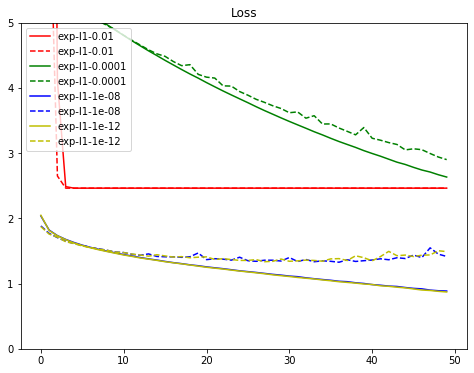

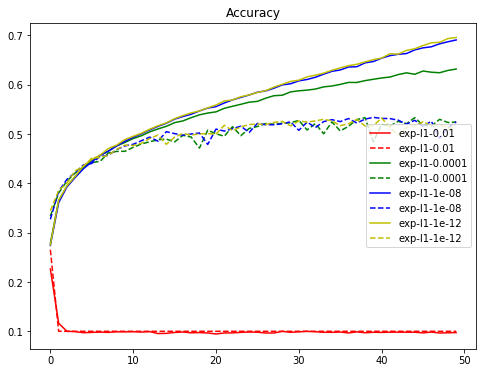

In [10]:
import matplotlib.pyplot as plt

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()